### Tabular DynaQ for the Simple Maze problem in figures 8.2 and 8.3

Start by creating the simple maze, grid world, as illustrated in figures 8.2 and 8.3. Two function are used, one to tell us if a state is valid within the maze and the other is used to take action within the maze (environment), this function returns the new state and immediate reward.

In [1]:
import numpy as np

# create a grid world, tell us if this state exists in this world
def gridworld(s):
    nw = 6
    mw = 9
    world = np.zeros((nw+2,mw+2), dtype = bool)
    world[1:(nw+1),1:(mw+1)] = True
    world[2:5,3] = False
    world[5,6] = False
    world[1:4,8] = False
    return world[s[0],s[1]]
# the environment:
def takeaction(s, a):
    step = np.array([[-1,0],[1,0],[0,-1],[0,1]])
    snew = s + step[a]
    r = 0.0
    if gridworld(snew) == True:
        sterminal = np.array([1,9]) # the goal state
        if np.all(snew == sterminal):
            r = 1.0
    else:
        snew = s # stay in same location
    return snew, r

The policy uses in the usual $\epsilon$-greedy function, here we would like to break ties randomly:

In [2]:
# a random tie-breaking argmax (code "found" on stackexchange)
def randargmax(b,**kw):
  return np.argmax(np.random.random(b.shape) * (b==b.max()), **kw)

def epsilongreedy(epsilon, s, Q):
    if (np.random.uniform() < epsilon):
        a = np.random.choice(range(4),1)[0]
    else:
        a = randargmax(Q[s[0],s[1],:])
    return a

Here I implement the tabular-Dyna-Q algorithm. One aspect that could have been made clearer in the textbooks's pseudocode is that the epsisode continues (after the planning phase) from where it left off, else the procedure makes no sense.

In [3]:
# let the two variables A(s,a) (state) and B(s,a) (reward) represent our Model 
# here we are using the same notation as in the Dyna2 paper
def TabularDynaQ(gamma, epsilon, alpha, n):
    nw = 6
    mw = 9
    Q = np.zeros((nw+2,mw+2,4))
    A = np.zeros((nw+2,mw+2,4,2), dtype = int)
    B = np.zeros((nw+2,mw+2,4,1), dtype = int)
    Observed = np.zeros((nw+2,mw+2,4), dtype = bool)
    forever = True
    episode = 0
    stepcount = np.zeros(50) # lets keep track of the steps needed to reach our terminal state!
    while forever == True:
        s = np.array([3,1]) # initial state
        sterminal = np.array([1,9]) # the goal state
        while np.all(s==sterminal) == False:
            stepcount[episode] += 1
            a = epsilongreedy(epsilon,s,Q)
            snew, R = takeaction(s,a)
            Q[s[0],s[1],a] += alpha*(R+gamma*np.max(Q[snew[0],snew[1],:])-Q[s[0],s[1],a])
            A[s[0],s[1],a,:] = snew
            B[s[0],s[1],a,0] = R
            Observed[s[0],s[1],a] = True # Bookkeepping, record that we have visited this (state, action) before
            ob = np.where(Observed == True) # which have been observed?
            nob = len(ob[0]) # the number of observations
            skeep = snew # this is missing in the Dyna-Q code p. 164 in book
            akeep = a
            for repeat in range(n): # in search, planning or dreaming mode:
                choice = np.random.choice(range(nob),1)[0]
                s = [ob[0][choice], ob[1][choice]]
                a = ob[2][choice]
                R = B[s[0],s[1],a,0] 
                snew = A[s[0],s[1],a,:]
                Q[s[0],s[1],a] += alpha*(R+gamma*np.max(Q[snew[0],snew[1],:])-Q[s[0],s[1],a])
            s = skeep # restore the true state before planning phase
            a = akeep
        episode += 1 
        if episode >= 50:
            forever = False # nothing is forever :)
    return Q, stepcount

OK, now we are ready to perform some experiments:

In [4]:
# to get a smoother picture than the one in figure 8.2 we will repeat the experiment M times
def experiment(gamma, epsilon, alpha, n, M):
    Q, StepCount = TabularDynaQ(gamma, epsilon, alpha, n)  
    for i in range(M-1):
        _, sc = TabularDynaQ(gamma, epsilon, alpha, n)  
        StepCount = StepCount + sc
    StepCount = StepCount/M
    return Q, StepCount

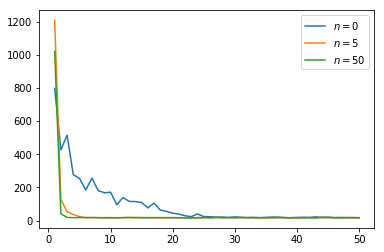

In [5]:
gamma = 0.95
alpha = 0.1
epsilon = 0.1
M = 10
%matplotlib inline
import matplotlib.pyplot as plt
for n in [0,5,50]:
    Q, StepCount = experiment(gamma,epsilon, alpha, n, M)
    plt.plot(range(1,51),StepCount, label = "$n=$" + str(n))
plt.legend(loc='upper right')
plt.show()

You may also find it interesting to see one of the learned policies in this case the last experiment with $n = 50$:

In [6]:
def printpolicy(Q):
    np.set_printoptions(threshold=np.nan)
    symbol = ['✪','⇧','⇩','⇦','⇨','☺','☹']
    n = 6
    m = 9
    I = np.zeros((n+2,m+2), dtype = int)
    I[1:n+1,1:m+1] = 1+np.argmax(Q[1:n+1,1:m+1,:], axis=2)
    I[2:5,3] = 0
    I[5,6] = 0
    I[1:4,8] = 0
    I[3,1] = 6
    I[1,9] = 5
    Grid = np.zeros((n+2,m+2), dtype = 'U1')
    for i in range(7): Grid[I == i] = symbol[i]
    print(Grid)

In [7]:
printpolicy(Q)

[['✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪']
 ['✪' '⇩' '⇩' '⇦' '⇦' '⇧' '⇧' '⇧' '✪' '☺' '✪']
 ['✪' '⇩' '⇩' '✪' '⇧' '⇧' '⇧' '⇩' '✪' '⇧' '✪']
 ['✪' '☹' '⇩' '✪' '⇧' '⇩' '⇦' '⇦' '✪' '⇧' '✪']
 ['✪' '⇨' '⇩' '✪' '⇩' '⇩' '⇧' '⇨' '⇨' '⇧' '✪']
 ['✪' '⇨' '⇨' '⇨' '⇩' '⇩' '✪' '⇧' '⇦' '⇧' '✪']
 ['✪' '⇨' '⇨' '⇨' '⇨' '⇨' '⇨' '⇧' '⇦' '⇧' '✪']
 ['✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪' '✪']]


### Trying out Dyna-2 for the same problem

This implementation is a Q-learning version of Dyna-2 using a tabular Q action-value function. First we must implement a $\epsilon$-greedy strategy for all actions observed in give state $s$:

In [8]:
def epsilongreedyobserved(epsilon, s, Qt, Observed):
    if (np.random.uniform() < epsilon):
        a = np.random.choice(np.where(Observed[s[0],s[1],:])[0],1)[0]
    else:
        qt = Qt[s[0],s[1],:]
        qt[Observed[s[0],s[1],:] == False] = np.min(qt)-1.0 # make sure these are the smallest
        a = randargmax(qt)
    return a

The search stretgy is episodic and is the equivalent to the planning (dream) mode above.

In [9]:
def search(skeep, epsilon, Q, Qt, A, B, Observed, n):
    iter = 0                     # or until maximum number of iterations
    sterminal = np.array([1,9])  # the goal state
    if np.all(skeep==sterminal) == True:
        return 0
    if np.all(Observed[skeep[0],skeep[1],:] == False) == True:
        return 0 # there is no data for this starting episode
    while iter < n:
        s = skeep # start a new episode:
        a = epsilongreedyobserved(epsilon, s, Q+Qt, Observed)
        while np.all(s==sterminal) == False:
            iter += 1
            snew = A[s[0],s[1],a,:]
            R = B[s[0],s[1],a,0]
            if np.all(Observed[snew[0],snew[1],:] == False) == True:
                break # our model ends here (no more data)
            Qbarnew = Qt[snew[0],snew[1],Observed[snew[0],snew[1],:]]+Q[snew[0],snew[1],Observed[snew[0],snew[1],:]]
            Qbar = Qt[s[0],s[1],a] + Q[s[0],s[1],a]
            Qt[s[0],s[1],a] += alpha*(R+gamma*np.max(Qbarnew)-Qbar)
            if iter >= n: 
                break # the episode has used up its budget n
            a = epsilongreedyobserved(epsilon, snew, Q+Qt, Observed)
            s = snew
    return 1

And the TabularDyna2Q can then be written as:

In [10]:
def TabularDyna2episodicQ(gamma, epsilon, alpha, n):
    nw = 6
    mw = 9
    Q = np.zeros((nw+2,mw+2,4)) # clear permanent memory
    A = np.zeros((nw+2,mw+2,4,2), dtype = int)
    B = np.zeros((nw+2,mw+2,4,1), dtype = int)
    Observed = np.zeros((nw+2,mw+2,4), dtype = bool)
    forever = True
    episode = 0
    stepcount = np.zeros(50)
    while forever == True:
        s = np.array([3,1]) # initial state (start state)
        Qt = np.zeros((nw+2,mw+2,4)) # clear transient memory
        search(s, epsilon, Q, Qt, A, B, Observed, n)
        a = epsilongreedy(epsilon, s, Q + Qt)
        sterminal = np.array([1,9]) # the goal or terminal state
        while np.all(s == sterminal) == False:
            stepcount[episode] += 1
            snew, R = takeaction(s,a)
            A[s[0],s[1],a,:] = snew
            B[s[0],s[1],a,0] = R
            Observed[s[0],s[1],a] = True # record that we have visited this (state,action)
            search(snew, epsilon, Q, Qt, A, B, Observed, n)
            anew = epsilongreedy(epsilon, snew, Q + Qt)
            delta = R + np.max(Q[snew[0],snew[1],:]) - Q[s[0],s[1],a]
            Q[s[0],s[1],a] += alpha*delta
            s = snew
            a = anew
        episode += 1 
        if episode >= 50:
            forever = False
    return Q, stepcount

Now lets repeat the experiments above using this version of DynaQ

In [11]:
def experiment2(gamma, epsilon, alpha, n, M):
    Q, StepCount = TabularDyna2episodicQ(gamma, epsilon, alpha, n)  
    for i in range(M-1):
        _, sc = TabularDyna2episodicQ(gamma, epsilon, alpha, n)  
        StepCount = StepCount + sc
    StepCount = StepCount/M
    return Q, StepCount

Lets run it and add to the plot above:

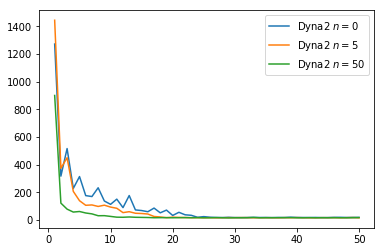

In [12]:
%matplotlib inline
for n in [0,5,50]:
    Q, StepCount = experiment2(gamma,epsilon, alpha, n, M)
    plt.plot(range(1,51),StepCount, label = "Dyna2 $n=$" + str(n))
plt.legend(loc='upper right')
plt.show()

The DynaQ learns faster than the Dyna2Q for this task. This would seem to make sense since only the transient memory is updated during search, unlike DynaQ where the permanent memory is updated during search. The search in Dyna2Q only influences the policy used when taking real actions, and so helps in making better actions when using the avarage Q values between the permanent and transient memories. 

If there is no permanent memory, then Dyna-2 reduces to a sample-based search algorithm. For example, Monte-Carlo tree search is achieved by choosing table lookup; using a simulation policy that is greedy within the tree, and then uniform random until termination; and selecting learning parameters $\alpha = 1/n(s, a)$, where $n(s, a)$
counts the number of times that action a has been selected in state $s$. The UCT algorithm replaces the
greedy phase of the simulation policy with the UCB rule for action selection.

In order to implement the MCTS (UCT), then during search we would need to perform rollouts once we reach a leaf node in our tree. In my code above I just bail out and say that there is no more data (actions) in our model. However, the MCTS may explore an action never taken before and use a fixed policy (uniform random) from then on until a terminal state. This requires, however, an environment simulator, which we did not have above (i.e. the model came short).